In [107]:
# Instalacje
# !pip install NRCLex
# !pip install contractions
# !pip install nlpaug 
# !pip install transformers 
# !pip install deep_translator 
# !pip install tqdm
# !pip install torch
# !pip install symspellpy langdetect
# !pip install sentencepiece

# Pobieranie danych NLTK
# nltk.download('sentiwordnet')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('vader_lexicon')
# nltk.download('stopwords')

# Ładowanie bibliotek
import pandas as pd
import string
import re
import random
import tqdm
import time
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Importy związane z NLP (Natural Language Processing)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, sentiwordnet as swn, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk import download

# Importy związane z wykrywaniem języka
from langdetect import detect

# Importy do poprawiania literówek
from symspellpy import SymSpell, Verbosity

# Biblioteki do tłumaczenia
from deep_translator import GoogleTranslator

# Importy do analizy sentymentu
from nrclex import NRCLex
from textblob import TextBlob

# Przetwarzanie tekstów
import contractions

# Importy do skali i przetwarzania danych
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [108]:
df=pd.read_csv("YoutubeCommentsDataSet.csv")

In [109]:
#Analiza wizualna danych
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [110]:
df.columns.values.tolist()

['Comment', 'Sentiment']

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [112]:
#Widzimy że mamy puste komentarze, które posiadają sentyment - sprawdźmy jaki mają sentyment!

In [113]:
null_comments = df[df["Comment"].isnull()]
null_comments

,Comment,Sentiment
602,NaN,negative
716,NaN,neutral
812,NaN,positive
1021,NaN,positive
1023,NaN,neutral
1041,NaN,positive
1094,NaN,positive
2443,NaN,positive
3014,NaN,positive
3235,NaN,positive


In [114]:
#Jak widzimy nie ma tutaj żadnego schematu, z tego powodu usuniemy te komentarze, ponieważ nie mamy jak analizować ich sentymentu

**WALIDACJA**


---
Dobre posunięcie, z usunięciem nic niewnoszących danych 👍


**BUDOWA**

---
Ostatecznie postanowiliśmy nie usuwać danych NA aby nie stracić możliwości nauczenia modelu radzenia sobie z takimi danymi

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [118]:
df['Clean_Comment'] = df['Comment'].str.replace(f"[{string.punctuation}]", "", regex=True)
import string
import pandas as pd

# Dla komentarzy NA zamieniamy je na pusty komentarz ''
df['Clean_Comment'] = df['Comment'].fillna('').apply(lambda x: ''.join([char.lower() for char in x if char not in string.punctuation]))

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def is_emotional(word):
    emotions = NRCLex(word).affect_frequencies
    return any(value > 0 for value in emotions.values())

filtered_stop_words = {word for word in stop_words if not is_emotional(word)}

def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()

    text = contractions.fix(text)

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words or word == "not"]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if word not in punctuation]

    return " ".join(tokens)
df['Clean_Comment'] = df['Comment'].apply(preprocess_text)
df['Tokenized_Comment'] = df['Clean_Comment'].apply(lambda x: x.split())

In [119]:



# Inicjalizujemy SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "frequency_dictionary_en_82_765.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Inicjujemy lematyzator i stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Funkcja do wykrywania języka (usuwamy komentarze, które nie są po angielsku)
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Funkcja do usuwania literówek za pomocą SymSpell
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)  # Wybieramy najbliższe słowo
        else:
            corrected_words.append(word)
    
    return " ".join(corrected_words)

# Usuwamy nieangielskie komentarze
df['Clean_Comment'] = df['Comment'].apply(lambda x: x if is_english(x) else None)

# Funkcja do przetwarzania tekstu
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Zamiana na małe litery
    text = text.lower()
    
    # Rozwiązywanie skrótów (np. don't -> do not)
    text = contractions.fix(text)
    
    # Tokenizacja
    tokens = word_tokenize(text)
    
    # Usuwanie stopwords
    tokens = [word for word in tokens if (word not in stop_words or word == "not")]
    
    # Lematyzacja
    tokens = [lemmatizer.lemmatize(word) for word in tokens ]
    
    # Usuwanie znaków interpunkcyjnych
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Poprawianie literówek
    text = correct_spelling(" ".join(tokens))
    
    return text

# Przetwarzanie danych
df['Clean_Comment'] = df['Clean_Comment'].apply(preprocess_text)
df['Tokenized_Comment'] = df['Clean_Comment'].apply(lambda x: x.split())

# Wyświetlenie przetworzonych danych
print(df[['Comment', 'Clean_Comment']].head())


                                             Comment  \
0  lets not forget that apple pay in 2014 require...   
1  here in nz 50 of retailers don’t even have con...   
2  i will forever acknowledge this channel with t...   
3  whenever i go to a place that doesn’t take app...   
4  apple pay is so convenient secure and easy to ...   

                                       Clean_Comment  
0  let a not forget apple pay 2014 required brand...  
1  no of retailer not even contactless credit car...  
2  forever acknowledge channel help lesson idea e...  
3  whenever go place not take apple pay not happe...  
4  apple pay convenient secure easy use used kore...  


In [120]:
df["Comment"] = df["Clean_Comment"]
df.drop(columns=["Clean_Comment"], inplace=True)  # Usuwamy starą kolumnę

In [121]:
#Analiza ilościowa danych

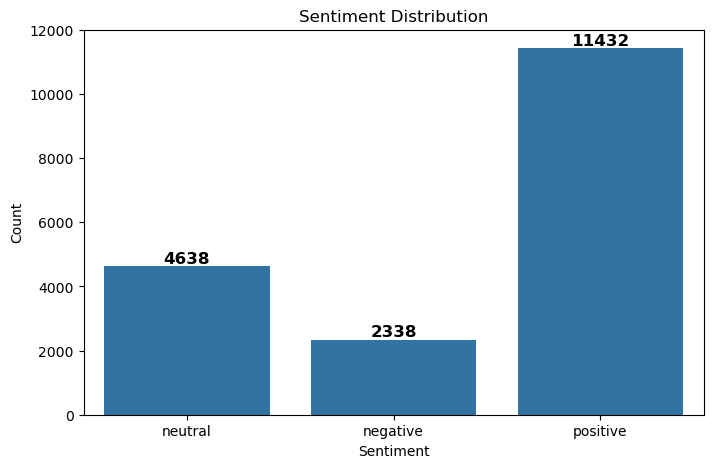

In [122]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df["Sentiment"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

**WALIDACJA**


---

Zastanówcie się nad zbalansowaniem danych. Rekordów "positive" jest znacznie więcej niż "negative". Może to powodować sytuację, że model będzie ignorował negatywne komentarze. W takim wypadku konieczne jest zbalansowanie danych np. metodą undersamplingu lub oversamplingu.

**Budowa**


---

Świadomie zdecydowaliśmy się nie balansować danych, aby nie zaburzyć rzeczywistej struktury populacji. Naszym celem jest stworzenie modelu, który będzie odzwierciedlał faktyczny rozkład klas w danych i nauczył się odpowiednio reagować na naturalne proporcje między pozytywnymi a negatywnymi przykładami.

In [125]:
df["length"]=df["Comment"].apply(len)
df.head()

,Comment,Sentiment,Tokenized_Comment,length
0,let a not forget apple pay 2014 required brand...,neutral,"[let, a, not, forget, apple, pay, 2014, requir...",237
1,no of retailer not even contactless credit car...,negative,"[no, of, retailer, not, even, contactless, cre...",109
2,forever acknowledge channel help lesson idea e...,positive,"[forever, acknowledge, channel, help, lesson, ...",105
3,whenever go place not take apple pay not happe...,negative,"[whenever, go, place, not, take, apple, pay, n...",295
4,apple pay convenient secure easy use used kore...,positive,"[apple, pay, convenient, secure, easy, use, us...",91


In [126]:
#Dzielimy komentarze na: bardzo krótkie, krótkie, średnie oraz długie

In [127]:
bins = [0,100, 250, 1000, float("inf")]
labels = ["0-100","100-250", "250-1000", "1000+"]

df["comment_length_bin"] = pd.cut(df["length"], bins=bins, labels=labels, right=False)


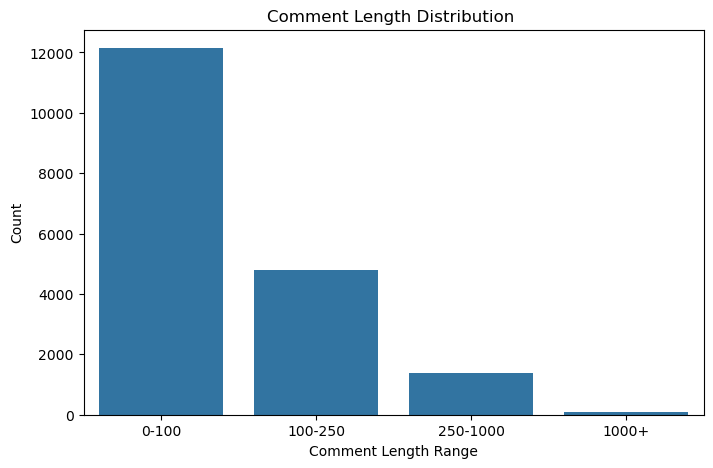

In [128]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["comment_length_bin"], order=labels)
plt.title("Comment Length Distribution ")
plt.xlabel("Comment Length Range")
plt.ylabel("Count")
plt.show()

**WALIDACJA**


---

Jakieś wnioski? 🤔

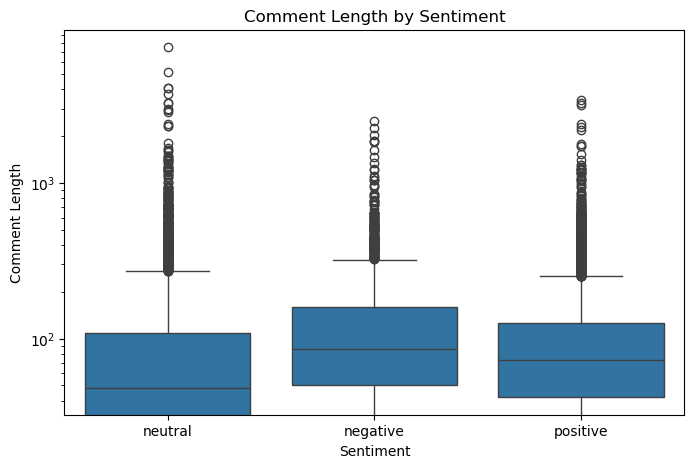

In [130]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Sentiment", y="length", data=df)
plt.yscale("log")
plt.title("Comment Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Comment Length")
plt.show()


**WALIDACJA**


---

Na wykresie widać dużo wartości odstających - gdyby było ich mniej dobrze byłoby je usunąć/zamienić na wartości z dolnej granocy. Jednak przy tak dużej ilości trzeba się zastanowić, czy jest to słuszne rozwiązanie - czy nie wpłynie na skuteczność modelu

**BUDOWA**


---

Podjęliśmy decyzję o pozostaniu przy oryginalnych danych, naturalnym dla danych typu komentarzy jest, że najwięcej jest tych krótszych w związku z czym nie będziemy zmieniać populacji.

In [133]:
## VADER
#Wykorzystujemy bibliotekę vader która analizuje sentyment wypowiedzi na podstawie użytych w nich słów, emotikonów oraz znaków interpunkcyjnych np. "!!!"
#Poszczególne kolumny vader_pos, vader_neg, vader_neu, vader_score oznaczają odpowiednio:
#Odsetek negatywnych emocji (wartość od 0 do 1).
#Odsetek neutralnych emocji (wartość od 0 do 1).
#Odsetek pozytywnych emocji (wartość od 0 do 1).
#Złożony wynik sentymentu (od -1 do +1).

In [134]:
sia = SentimentIntensityAnalyzer()

In [135]:
def count_sentiment_words(comment):
    scores = sia.polarity_scores(comment)
    return scores['pos'], scores['neg'], scores['neu'], scores['compound']

In [136]:
df[['vader_pos', 'vader_neg','vader_neu', 'vader_score']] = df['Comment'].apply(lambda x: pd.Series(count_sentiment_words(x)))

In [137]:
df.head()

,Comment,Sentiment,Tokenized_Comment,length,comment_length_bin,vader_pos,vader_neg,vader_neu,vader_score
0,let a not forget apple pay 2014 required brand...,neutral,"[let, a, not, forget, apple, pay, 2014, requir...",237,100-250,0.261,0.000,0.739,0.7401
1,no of retailer not even contactless credit car...,negative,"[no, of, retailer, not, even, contactless, cre...",109,100-250,0.291,0.218,0.491,0.4434
2,forever acknowledge channel help lesson idea e...,positive,"[forever, acknowledge, channel, help, lesson, ...",105,100-250,0.527,0.000,0.473,0.8795
3,whenever go place not take apple pay not happe...,negative,"[whenever, go, place, not, take, apple, pay, n...",295,250-1000,0.079,0.255,0.666,-0.8608
4,apple pay convenient secure easy use used kore...,positive,"[apple, pay, convenient, secure, easy, use, us...",91,0-100,0.409,0.073,0.518,0.7579


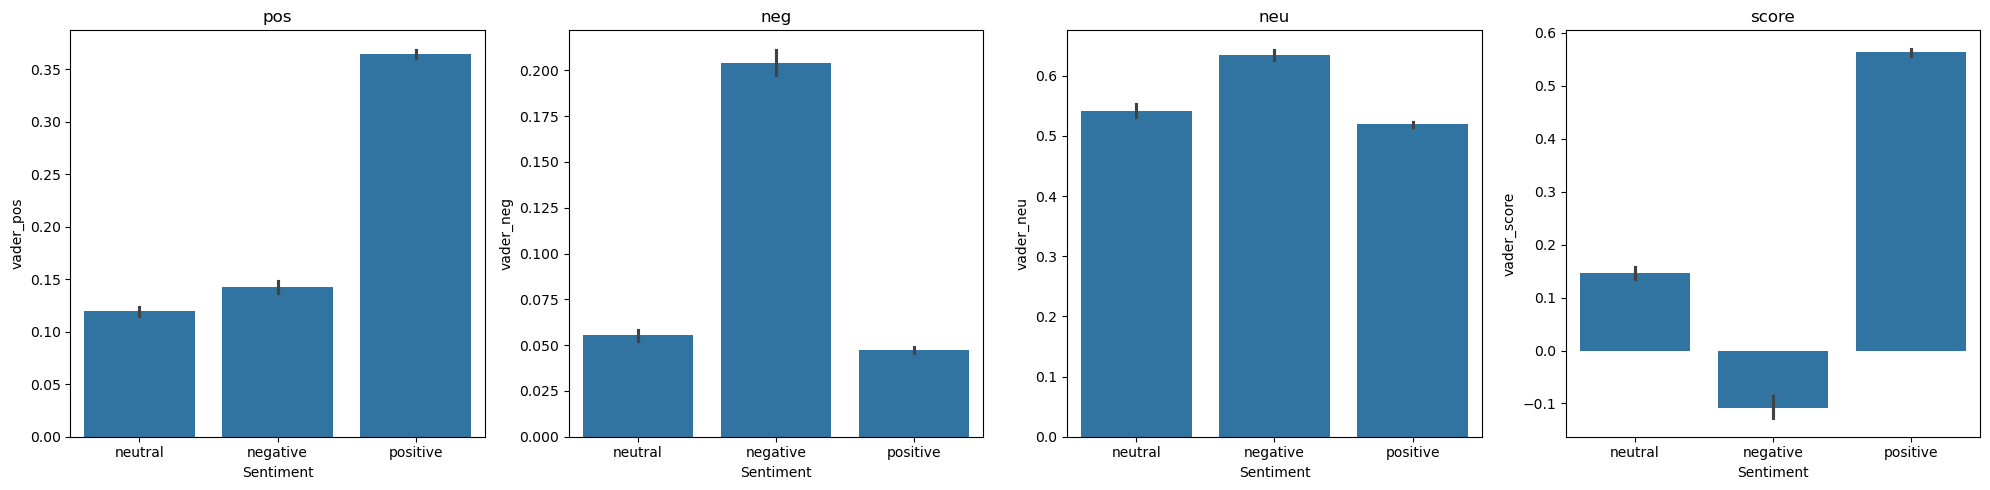

In [138]:
#Analiza wyników działania vadera na podstawie sentymentu wypowiedzi
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
sns.barplot(data = df, x = 'Sentiment', y = 'vader_pos',ax = axs[0])
sns.barplot(data = df, x = 'Sentiment', y = 'vader_neg',ax = axs[1])
sns.barplot(data = df, x = 'Sentiment', y = 'vader_neu', ax = axs[2])
sns.barplot(data = df, x = 'Sentiment', y = 'vader_score', ax = axs[3])
axs[0].set_title('pos')
axs[1].set_title('neg')
axs[2].set_title('neu')
axs[3].set_title('score')
plt.tight_layout()
plt.show()

**WALIDACJA**


---

Widać, że wyniki funckji vader oraz wartości w kolumnie Sentiment pokrywają się - to dobrze :). Jedyne co to w varder_score jest duża dysproporcja pomiędzy positive a neutral, a między neutral a negative już nie tak bardzo, warto się zastanowić dlaczego tak jest?

**BUDOWA**


---

Dysproporcja w vader_score wynika z tego, że komentarzy pozytywnych jest znacznie więcej w porównaniu do innych.

In [141]:
scaler = MinMaxScaler()
df[['vader_score_norm']] = scaler.fit_transform(df[['vader_score']])

**WALIDACJA**


---

Przydałyby się jakieś komentarze wyjaśniające co robicie :(

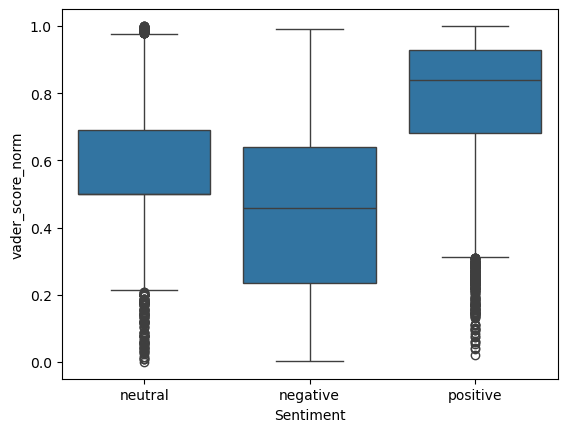

In [143]:
sns.boxplot(data = df, x = 'Sentiment', y = 'vader_score_norm')
plt.show()

**WALIDACJA**


---

Ta sama sytuacja co powyżej - dużo wartości odstających, co z nimi zrobić?

In [145]:
df.head()

,Comment,Sentiment,Tokenized_Comment,length,comment_length_bin,vader_pos,vader_neg,vader_neu,vader_score,vader_score_norm
0,let a not forget apple pay 2014 required brand...,neutral,"[let, a, not, forget, apple, pay, 2014, requir...",237,100-250,0.261,0.000,0.739,0.7401,0.870027
1,no of retailer not even contactless credit car...,negative,"[no, of, retailer, not, even, contactless, cre...",109,100-250,0.291,0.218,0.491,0.4434,0.721365
2,forever acknowledge channel help lesson idea e...,positive,"[forever, acknowledge, channel, help, lesson, ...",105,100-250,0.527,0.000,0.473,0.8795,0.939874
3,whenever go place not take apple pay not happe...,negative,"[whenever, go, place, not, take, apple, pay, n...",295,250-1000,0.079,0.255,0.666,-0.8608,0.067893
4,apple pay convenient secure easy use used kore...,positive,"[apple, pay, convenient, secure, easy, use, us...",91,0-100,0.409,0.073,0.518,0.7579,0.878946


**WALIDACJA**


---


SUPER PRACA ‼️‼️‼️🥳🥳🥳😎😎😎